In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [92]:
# Read the CSV files
raw_df = pd.read_csv('../data/RAW_INTEGRATION.csv')
clean_df = pd.read_csv('../data/INT_clean_TEMP_sensor.csv')
target_df = pd.read_csv('../data/INT_target.csv')

#Format time colums
raw_df['Time'] = pd.to_datetime(raw_df['Time'])
clean_df['Time'] = pd.to_datetime(clean_df['Time'])
target_df['Time'] = pd.to_datetime(target_df['Time'])

# Load the model from the .keras file
model = load_model('../src/model.keras')

In [93]:
# Copy clean_df so we don't alter the original data
model_df = clean_df.copy()

# Preprocess the Time column in the same way
model_df['Time'] = pd.to_datetime(model_df['Time'])
model_df.set_index('Time', inplace=True)
model_df.sort_index(inplace=True)

# Extract the hour from the 'Time' index
model_df['Hour'] = model_df.index.hour

# Create cyclical features using sine and cosine for 'Hour'
model_df['Hour_sin'] = np.sin(2 * np.pi * model_df['Hour'] / 24)
model_df['Hour_cos'] = np.cos(2 * np.pi * model_df['Hour'] / 24)

# Drop the 'Hour' column as it's no longer needed
model_df.drop(columns=['Hour'], inplace=True)

# Scale the 'State' values (temperature readings)
scaler = MinMaxScaler()
model_df['State'] = scaler.fit_transform(model_df[['State']])

# Check the resulting DataFrame
print(model_df.head())

                        State       Device Unit  Hour_sin  Hour_cos
Time                                                               
2024-09-13 20:58:01  0.863636  TEMP_sensor    C -0.866025       0.5
2024-09-13 20:58:26  0.863636  TEMP_sensor    C -0.866025       0.5
2024-09-13 20:58:51  0.909091  TEMP_sensor    C -0.866025       0.5
2024-09-13 20:59:16  0.909091  TEMP_sensor    C -0.866025       0.5
2024-09-13 20:59:41  0.909091  TEMP_sensor    C -0.866025       0.5


In [94]:
# Function to create sequences
def create_sequences(data, input_steps=10, output_steps=48):
    X, y = [], []
    
    for i in range(len(data) - input_steps - output_steps + 1):
        # Include both the 'State', 'Hour_sin', and 'Hour_cos' in the input
        X.append(data[['State', 'Hour_sin', 'Hour_cos']].iloc[i:i+input_steps].values)
        y.append(data['State'].iloc[i+input_steps:i+input_steps+output_steps].values)
        
    return np.array(X), np.array(y)

# Create sequences from the model_df
X_model, y_real = create_sequences(model_df)

# Reshape the input sequences to fit the LSTM model format
X_model = X_model.reshape((X_model.shape[0], X_model.shape[1], 3))

In [95]:
# Predict using the model
y_pred_model = model.predict(X_model)

# Reshape the predicted values for inverse transformation
y_pred_flat = y_pred_model.reshape(-1, 1)

# Inverse transform to get the original scale
y_pred_inverse = scaler.inverse_transform(y_pred_flat)

# Reshape the predictions back to their original shape
y_pred_inverse = y_pred_inverse.reshape(y_pred_model.shape)

# Flatten the arrays for comparison
y_pred_flat = y_pred_inverse.flatten()

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


In [96]:
# Reshape y_pred_inverse so that each row represents the 48 future predictions
y_pred_reshaped = y_pred_inverse.reshape(-1, 48)

# Take the last prediction (48th step) from each sequence
y_pred_last = y_pred_reshaped[:, -1]  # Take the last prediction for each sequence

# Ensure the lengths match by shifting the index of real values forward by 48 steps
min_length = min(len(model_df['State']) - 48, len(y_pred_last))  # Adjust for shift

# Create a new DataFrame with time-shifted real and predicted values
comparison_df = pd.DataFrame({
    'Time': model_df.index[48:48 + min_length],  # Shift the real values forward by 48 steps
    'Real_State': model_df['State'][48:48 + min_length],  # Real values, shifted forward by 48
    'Predicted_State': y_pred_last[:min_length]  # Corresponding last predicted values
})

# Inverse transform the real state values for comparison
comparison_df['Real_State'] = scaler.inverse_transform(comparison_df[['Real_State']])

# Set Time as the index again for plotting convenience
comparison_df.set_index('Time', inplace=True)

# Check the resulting DataFrame with real vs predicted values
print(comparison_df.head())


                     Real_State  Predicted_State
Time                                            
2024-09-13 21:18:01   21.821650        21.829966
2024-09-13 21:18:26   21.812990        21.829607
2024-09-13 21:18:51   21.767794        21.829363
2024-09-13 21:19:16   21.740676        21.823877
2024-09-13 21:19:41   21.724406        21.817091


In [97]:
raw_df_sliced = raw_df.iloc[320:480]
clean_df_sliced = clean_df.iloc[320:480]
target_df_sliced = target_df.iloc[310:470]
comparison_df_sliced = comparison_df.loc[raw_df_sliced['Time'].min():raw_df_sliced['Time'].max()]
comparison_df_sliced['Predicted_State'] = comparison_df_sliced['Predicted_State'] + 0.5

C:\Users\tiaan\AppData\Local\Temp\ipykernel_13788\2364328670.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df_sliced['Predicted_State'] = comparison_df_sliced['Predicted_State'] + 0.5


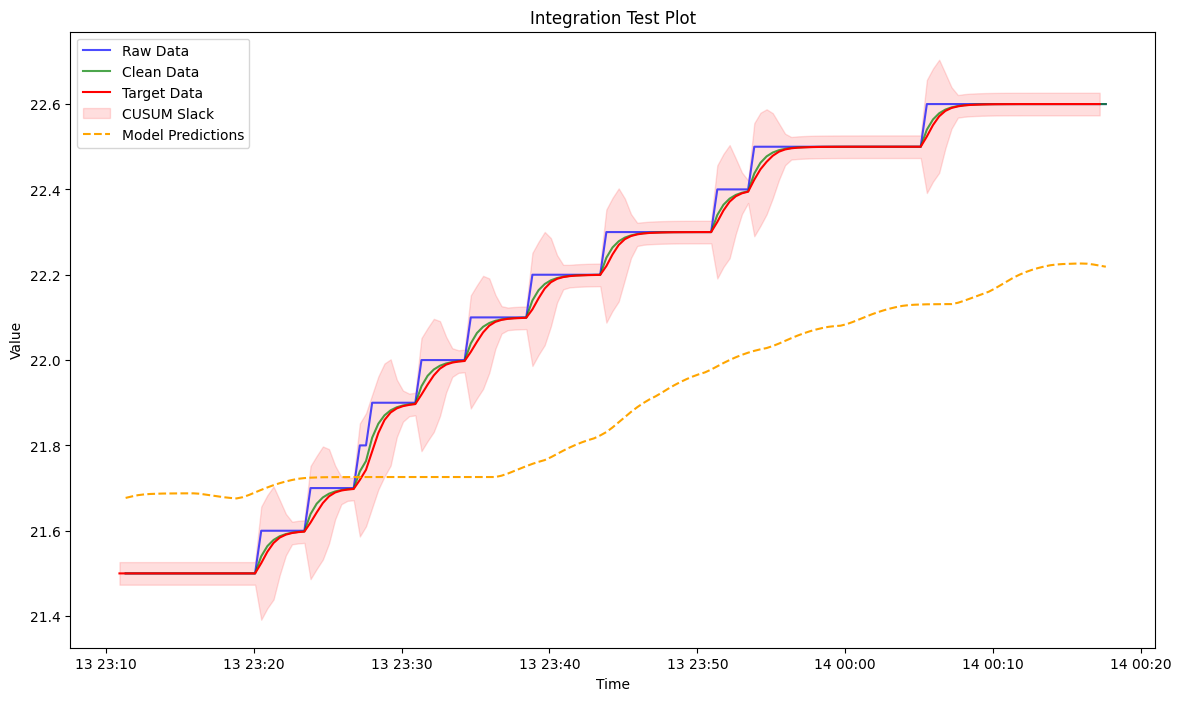

In [100]:
# Calculate the absolute gradient (rate of change) of the target data
gradient_abs = target_df_sliced['Target'].diff().abs()

# Replace NaN (first value) with zero to avoid NaN in calculations
gradient_abs.iloc[0] = 0

# Define a scaling factor to control the overall width of the CI
scaling_factor = (std_dev / 5.5) / gradient_abs.mean()

# Compute the CI width using the scaled gradient
CI_width = gradient_abs * scaling_factor

# Optionally, set minimum and maximum CI widths to avoid extreme values
min_CI_width = std_dev / 10
max_CI_width = std_dev / 2
CI_width = CI_width.clip(lower=min_CI_width, upper=max_CI_width)

# Define the confidence interval using the variable CI width
lower_bound = target_df_sliced['Target'] - CI_width/1.5
upper_bound = target_df_sliced['Target'] + CI_width/1.5

# Plot settings
plt.figure(figsize=(14, 8))

# Plot raw data (Time vs. State)
plt.plot(raw_df_sliced['Time'], raw_df_sliced['State'], label='Raw Data', color='blue', alpha=0.7)

# Plot clean data (Time vs. State)
plt.plot(clean_df_sliced['Time'], clean_df_sliced['State'], label='Clean Data', color='green', alpha=0.7)

# Plot target data (Time vs. Target) with confidence interval using fill_between
plt.plot(target_df_sliced['Time'], target_df_sliced['Target'], label='Target Data', color='red')

# Fill between to create the confidence interval
plt.fill_between(target_df_sliced['Time'], lower_bound, upper_bound, color='red', alpha=0.13, label='CUSUM Slack')

# Plot the model's predicted values for the same time window
plt.plot(comparison_df_sliced.index, comparison_df_sliced['Predicted_State'], label='Model Predictions', color='orange', linestyle='--')

# Add titles and labels
plt.title('Integration Test Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()